**VC-theory**

a) Чтобы точки можно было разделить, то они должны идти последовательно, сперва все плюсы, а потом все минусы (или наоборот). Число способов поставить перегородку отделюющую плюс от минуса это $n$. Еще надо как-то выбрать где плюсы, а где минусы, то есть умножить ответ на 2. Зная функцию найти breakpoint уже не представляет труда. 

Итого:

m<sub>H</sub>(n) = 2n, breakpoint=3, d_<sub>VC</sub>=2

б) Теперь требуется поставить 2 перегородки, причем надо дополнительно учесть случай, когда 2 перегородки  стоят с одной стороны. Тогда:

m<sub>H</sub>(n) = 2(n(n-1)/2 + 1)=n(n-1)+2, breakpoint=4, d_<sub>VC</sub>=3

In [135]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from scipy.special import expit

def read_dataset(path):
    df = pd.read_csv(path, skiprows=0)
    y = df['label'].to_numpy()
    X = df.drop('label', axis=1).to_numpy()
    return X, y

X_blobs, y_blobs = read_dataset('blobs2.csv')

**Perception**

In [255]:
def calc_accuracy(X, w, y):
    incorrect_indices = []
    for i, x in enumerate(X):
        if np.dot(x, w) * y[i] < 0:
            incorrect_indices.append(i)
    return 1 - len(incorrect_indices) / X.shape[0], incorrect_indices

def pocket_algorithm(X_train, y_train, X_test, y_test, max_iter=1000, poly_features=1):
    poly = PolynomialFeatures(poly_features)
    X_train = poly.fit_transform(X_train)
    X_test = poly.fit_transform(X_test)
    best_w = None
    best_acc = 0
    w = np.random.rand(X_train.shape[1])
    for i in range(max_iter):
        acc, _ = calc_accuracy(X_test, w, y_test)
        if acc > best_acc:
            best_w = w.copy()
            best_acc = acc
        
        _, incorrect_indices = calc_accuracy(X_train, w, y_train)
        to_be_fixed = np.random.choice(incorrect_indices)
        w += X_train[to_be_fixed] * y_train[to_be_fixed]
    
    return best_w, calc_accuracy(X_train, best_w, y_train)[0], calc_accuracy(X_test, best_w, y_test)[0]

def draw_perceptron(X, w, y, equation, title):
    plt.cla()
    first_class = X[y == 1]
    second_class = X[y == -1]

    plt.scatter(first_class[:, 0], first_class[:, 1], s=4)
    plt.scatter(second_class[:, 0], second_class[:, 1], s=4)
    
    delta = 0.025
    xrange = np.arange(np.min(X[:, 0]) - 0.5, np.max(X[:, 0]) + 0.5, delta)
    yrange = np.arange(np.min(X[:, 1]) - 0.5, np.max(X[:, 1]) + 0.5, delta)
    X, Y = np.meshgrid(xrange, yrange)
    Z = equation(X, Y, w) 
    plt.contour(X, Y, Z, [0])
    plt.title(title)
    plt.show()

def modify_labels(y):
    return (y - 0.5) * 2

X_train, X_test, y_train, y_test = train_test_split(X_blobs, y_blobs, test_size=0.2)
y_train = modify_labels(y_train)
y_test = modify_labels(y_test)

def find_and_draw_perceptron(degree, equation):
    w, train_acc, test_acc = pocket_algorithm(X_train, y_train, X_test, y_test, poly_features=degree)
    print(f'Train accuracy is {train_acc}')
    print(f'Test accuracy is {test_acc}')      

    draw_perceptron(X_train, w, y_train, equation, title='train')
    draw_perceptron(X_test, w, y_test, equation, title='test')

Train accuracy is 0.98125
Test accuracy is 0.985


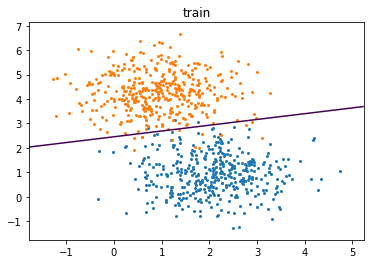

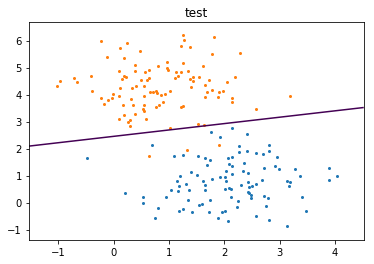

In [257]:
find_and_draw_perceptron(1, lambda x, y, w: w[0] + x * w[1] + y * w[2])

In [258]:
PolynomialFeatures(4).fit_transform(np.array([[1, 2], [3, 4]]))

array([[  1.,   1.,   2.,   1.,   2.,   4.,   1.,   2.,   4.,   8.,   1.,
          2.,   4.,   8.,  16.],
       [  1.,   3.,   4.,   9.,  12.,  16.,  27.,  36.,  48.,  64.,  81.,
        108., 144., 192., 256.]])

Train accuracy is 0.975
Test accuracy is 0.985


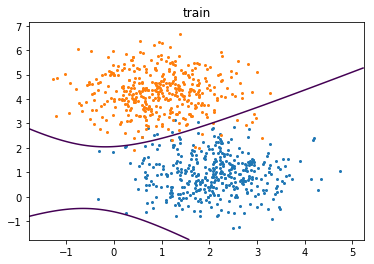

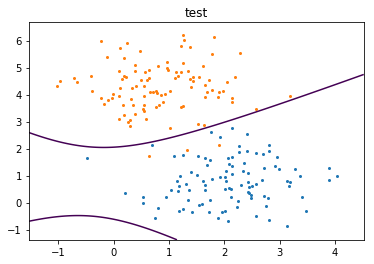

In [259]:
find_and_draw_perceptron(2, 
                         lambda x, y, w: w[0] + x * w[1] + y * w[2] +
                         x ** 2 * w[3] + x * y * w[4] + y ** 2 * w[5])

Train accuracy is 0.9775
Test accuracy is 0.985


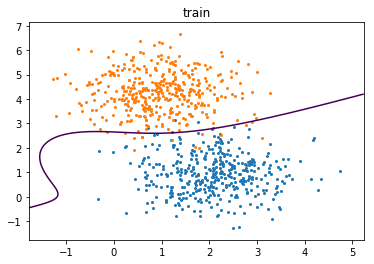

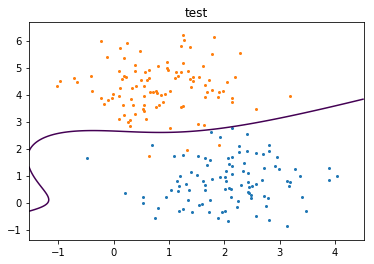

In [260]:
find_and_draw_perceptron(3, 
                         lambda x, y, w: w[0] + x * w[1] + y * w[2] +
                         x ** 2 * w[3] + x * y * w[4] + y ** 2 * w[5] +
                         x ** 3 * w[6] + x ** 2 * y * w[7] + x * y ** 2 * w[8] + y ** 3 * w[9])

Train accuracy is 0.97375
Test accuracy is 0.985


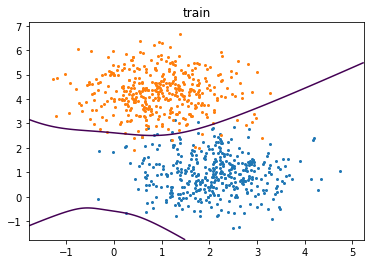

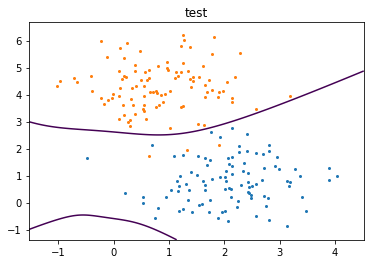

In [261]:
find_and_draw_perceptron(4, 
                         lambda x, y, w: w[0] + x * w[1] + y * w[2] +
                         x ** 2 * w[3] + x * y * w[4] + y ** 2 * w[5] +
                         x ** 3 * w[6] + x ** 2 * y * w[7] + x * y ** 2 * w[8] + y ** 3 * w[9] + 
                         x ** 4 * w[10] + x ** 3 * y * w[11] + (x * y) ** 2 * w[12] + x * y ** 3 * w[13] + y ** 4 * w[14])

**Logistic regression**

In [215]:
def logistic_regression(X, y, X_test, y_test, batch_size=30, epochs=50, learning_rate=0.05):
    X, X_test = PolynomialFeatures(1).fit_transform(X), PolynomialFeatures(1).fit_transform(X_test)
    w = np.random.rand(X.shape[1])
    batches = np.array_split(np.arange(X.shape[0]), X.shape[0] / batch_size)
    accuracies_test, accuracies_train = [], []
    for epoch in tqdm_notebook(range(epochs)):
        for batch in batches:
            grad = np.zeros_like(w)
            for i in batch:
                grad += y[i] * X[i] / (1 + np.exp(y[i] * np.dot(w, X[i])))
            w += grad / len(batch) * learning_rate
            accuracies_train.append(calc_accuracy(X, w, y)[0])
            accuracies_test.append(calc_accuracy(X_test, w, y_test)[0])
    return accuracies_train, accuracies_test

def draw_accuracy(accuracies_train, accuracies_test):
    plt.plot(range(len(accuracies_train)), accuracies_train, label='Train')
    plt.plot(range(len(accuracies_test)), accuracies_test, label='Test')
    plt.legend()
    plt.show()

def scale_data(data):
    return MinMaxScaler().fit_transform(data)            

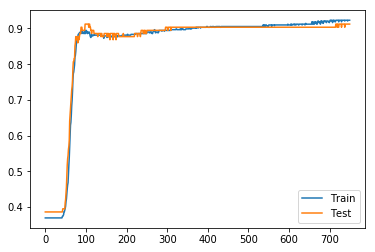

In [216]:
X_cancer, tmp_y_cancer = read_dataset('cancer.csv')
y_cancer = np.array([1 if l == 'M' else 0 for l in tmp_y_cancer])
X_cancer = scale_data(X_cancer)

X_train, X_test, y_train, y_test = train_test_split(X_cancer, y_cancer, test_size=0.2)
acc_train, acc_test = logistic_regression(X_train, modify_labels(y_train), X_test, modify_labels(y_test))
draw_accuracy(acc_train, acc_test)

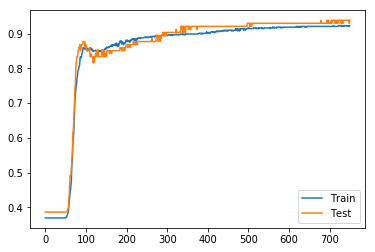

In [217]:
X_spam, y_spam = read_dataset('spam.csv')
X_spam = scale_data(X_spam)

X_train, X_test, y_train, y_test = train_test_split(X_cancer, y_cancer, test_size=0.2)
acc_train, acc_test = logistic_regression(X_train, modify_labels(y_train), X_test, modify_labels(y_test))
draw_accuracy(acc_train, acc_test)

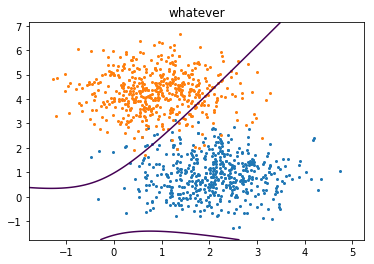

(0.926,
 [1,
  76,
  82,
  86,
  91,
  97,
  108,
  123,
  135,
  142,
  150,
  154,
  160,
  162,
  168,
  208,
  211,
  233,
  235,
  261,
  266,
  281,
  294,
  301,
  313,
  315,
  318,
  340,
  341,
  355,
  358,
  375,
  378,
  408,
  416,
  427,
  438,
  439,
  467,
  492,
  494,
  533,
  572,
  573,
  596,
  608,
  612,
  617,
  636,
  640,
  643,
  683,
  687,
  691,
  698,
  740,
  761,
  762,
  770,
  781,
  795,
  815,
  824,
  880,
  903,
  905,
  906,
  924,
  932,
  939,
  955,
  985,
  987,
  998])

In [266]:
draw_perceptron(X_blobs, [23.9990214, 19.86876931, -9.41210189, 10.86366881, 25.73413367,
-15.71494977], (y_blobs-0.5)*2, equation=lambda x, y, w: w[0] + x * w[1] + y * w[2] +
                         x ** 2 * w[3] + x * y * w[4] + y ** 2 * w[5], title='whatever')
calc_accuracy(PolynomialFeatures(2).fit_transform(X_blobs), [23.9990214, 19.86876931, -9.41210189, 10.86366881, 25.73413367,
-15.71494977], (y_blobs-0.5)*2)

**Neural networks**

In [268]:
X_mnist, y_mnist = read_dataset('mnist.csv')
len(y_mnist)

10000